In [3]:
import numpy as np
import matplotlib.pyplot as plt

plt.plot() 生成图表

plt.show() 展示图表

1. 线条样式
    -  '-' 实线
    -  '--' 虚线
    -  '-.' 点划线
    -  ':' 点线
2. 标记样式
    - '.' 点
    - ',' 像素
    - 'o' 圆形
    - 'x' 叉号
    - '+' 加号
3. 色彩简写
    - 'r' 'g' 'b' 'w' 'y' 红绿蓝白黄
    - 'k' black
    - 'c' cyan
    - 'm' magenta 洋红
4. 其他参数
    - alpha 透明度
    - linewidth 线条宽度
    - markersize 标记大小

设置坐标轴的范围和标签
1. axis([-10, 10, 30, 40])
2. ylim((30, 40))
3. xlabel("temperature")

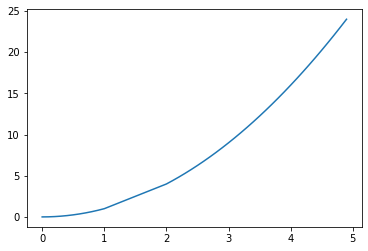

In [15]:
x = np.array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. , 2. , 2.1, 2.2, 2.3, 2.4, 2.5,
       2.6, 2.7, 2.8, 2.9, 3. , 3.1, 3.2, 3.3, 3.4, 3.5, 3.6, 3.7, 3.8,
       3.9, 4. , 4.1, 4.2, 4.3, 4.4, 4.5, 4.6, 4.7, 4.8, 4.9])
y = np.square(x)
plt.plot(x, y)      # 默认是线条
plt.show()

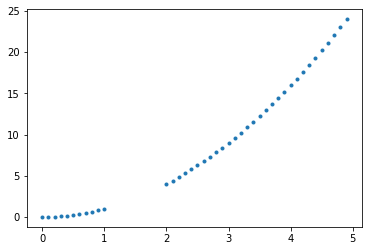

In [16]:
plt.plot(x, y, ".")

In [1]:
import copy
import csv
import functools
import glob
import os

from collections import namedtuple

import SimpleITK as sitk
import numpy as np

import torch
import torch.cuda
from torch.utils.data import Dataset

from util.disk import getCache
from util.util import XyzTuple, xyz2irc
from util.logconf import logging

In [7]:
CandidateInfoTuple = namedtuple(
    'CandidateInfoTuple',
    'isNodule_bool, diameter_mm, series_uid, center_xyz',
)

@functools.lru_cache(1)
def getCandidateInfoList(requireOnDisk_bool=True):
    # We construct a set with all series_uids that are present on disk.
    # This will let us use the data, even if we haven't downloaded all of
    # the subsets yet.
    mhd_list = glob.glob('G:/LUNA16/subset*/*.mhd')     # 得到很多个完整路径G:/foo/bar/114514.mhd
    presentOnDisk_set = {os.path.split(p)[-1][:-4] for p in mhd_list}   # 每个路径取114514.mhd部分再截取点前部分

    """
    从anno取, 到candi里挑选位置相差不大的
    """
    diameter_dict = {}
    with open('G:/LUNA16/annotations.csv', "r") as f:
        for row in list(csv.reader(f))[1:]:     # 从第二行开始, 读取一行信息
            series_uid = row[0]     # 获取这一行的第一个值seriesuid
            annotationCenter_xyz = tuple([float(x) for x in row[1:4]])      # 获取这一行的二三四值x,y,z
            annotationDiameter_mm = float(row[4])       # 获取这一行的第五个值d

            diameter_dict.setdefault(series_uid, []).append(    # 向[]内append
                # a.setdefault(key, value)等同于a[key]但键不存在时新建一个key-value键对
                (annotationCenter_xyz, annotationDiameter_mm)
            )

    candidateInfo_list = []
    with open('G:/LUNA16/candidates.csv', "r") as f:
        for row in list(csv.reader(f))[1:]:
            series_uid = row[0]

            if series_uid not in presentOnDisk_set and requireOnDisk_bool:
                continue        # 从csv获取的全部uid中选出那些在磁盘上的

            isNodule_bool = bool(int(row[4]))   # 从candidate.csv获取是否为结节的class 0/1
            candidateCenter_xyz = tuple([float(x) for x in row[1:4]])

            candidateDiameter_mm = 0.0
            for annotation_tup in diameter_dict.get(series_uid, []):    # 如果不是结节, 返回空[], 不会执行for
                annotationCenter_xyz, annotationDiameter_mm = annotation_tup
                for i in range(3):
                    delta_mm = abs(candidateCenter_xyz[i] - annotationCenter_xyz[i])
                    if delta_mm > annotationDiameter_mm / 4:
                        break       # 排除那些同uid但位置在candidate和annotation之间差太远的点
                else:   # 在for中未break的前提下, 最终执行, 正式把符合要求的点坐标传出去
                    candidateDiameter_mm = annotationDiameter_mm
                    break

            candidateInfo_list.append(CandidateInfoTuple(
                isNodule_bool,
                candidateDiameter_mm,
                series_uid,
                candidateCenter_xyz,
            ))

    candidateInfo_list.sort(reverse=True)   # sort descend
    return candidateInfo_list

In [ ]:
getCandidateInfoList()